# Brain Tumor Detection from MRI Images

## Project Overview

This notebook implements a complete binary classification pipeline to detect brain tumors from MRI scans.

**Dataset:** Brain MRI Images (yes/no tumor folders)  
**Task:** Binary classification (Tumor vs No Tumor)  
**Approach:** CNN  + Transfer Learning (EfficientNet-B0)



## Workflow
1. **Data Acquisition** — Load from Google Drive
2. **Data Exploration** — Class distribution, visualization, key visual cues
3. **Data Cleaning** — Verify file validity, check for corruption
4. **Data Preprocessing** — Resize, normalize, split (70/15/15), augmentation
5. **Model Design** — Custom CNN architecture
6. **Transfer Learning** — EfficientNet-B0 with pretrained weights
7. **Training & Evaluation** — TPR, TNR, Accuracy, F1, AUROC, Precision, Confusion Matrix, Learning Curves
8. **Explainable AI** —  Grad-CAM to highlight which parts of the image were important


---
# Part 1: Setup & Data Acquisition

In [ ]:
# =============================
# 0. Setup
# =============================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from collections import Counter

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import transforms

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)

# Reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)
print('PyTorch version:', torch.__version__)
print()
print('✅ Libraries imported')

Device: cpu
PyTorch version: 2.9.0+cpu

✅ Libraries imported


In [ ]:
# =============================
# 1. Data Acquisition
# =============================
# Mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

# Dataset paths
dataset_path  = '/content/drive/My Drive/brain_tumor_dataset'
tumor_path    = os.path.join(dataset_path, 'yes')   # Tumor images
no_tumor_path = os.path.join(dataset_path, 'no')    # No tumor images

print('Dataset path:', dataset_path)
print('Tumor folder:', tumor_path)
print('No tumor folder:', no_tumor_path)
print()
print('Folder structure preserved for supervised learning:')
print('  yes/ → label = 1 (Tumor)')
print('  no/  → label = 0 (No Tumor)')
print()
print('✅ Dataset loaded from Google Drive')

Mounted at /content/drive
Dataset path: /content/drive/My Drive/brain_tumor_dataset
Tumor folder: /content/drive/My Drive/brain_tumor_dataset/yes
No tumor folder: /content/drive/My Drive/brain_tumor_dataset/no

Folder structure preserved for supervised learning:
  yes/ → label = 1 (Tumor)
  no/  → label = 0 (No Tumor)

✅ Dataset loaded from Google Drive


---
# Part 2: Data Exploration and Understanding

In [ ]:
# =============================
# 2.1 Class Distribution
# =============================
# Count valid image files in each class
tumor_files    = [f for f in os.listdir(tumor_path)    if f.lower().endswith(('.jpg','.jpeg','.png'))]
no_tumor_files = [f for f in os.listdir(no_tumor_path) if f.lower().endswith(('.jpg','.jpeg','.png'))]

n_tumor    = len(tumor_files)
n_no_tumor = len(no_tumor_files)
n_total    = n_tumor + n_no_tumor

print('=' * 60)
print('CLASS DISTRIBUTION')
print('=' * 60)
print(f"🔴 Tumor (yes):     {n_tumor:>3d} images ({n_tumor/n_total*100:>5.1f}%)")
print(f"🟢No Tumor (no):   {n_no_tumor:>3d} images ({n_no_tumor/n_total*100:>5.1f}%)")
print(f'Total:           {n_total:>3d} images')
print(f'Imbalance ratio: {max(n_tumor, n_no_tumor)/min(n_tumor, n_no_tumor):.2f}:1')
print('=' * 60)
print()
if abs(n_tumor - n_no_tumor) / n_total > 0.1:
    print('⚠️  Classes are imbalanced')
    print('   → Will use class weights during training to compensate')
else:
    print('✅ Classes are reasonably balanced')

CLASS DISTRIBUTION
🔴 Tumor (yes):     155 images ( 61.3%)
🟢No Tumor (no):    98 images ( 38.7%)
Total:           253 images
Imbalance ratio: 1.58:1

⚠️  Classes are imbalanced
   → Will use class weights during training to compensate


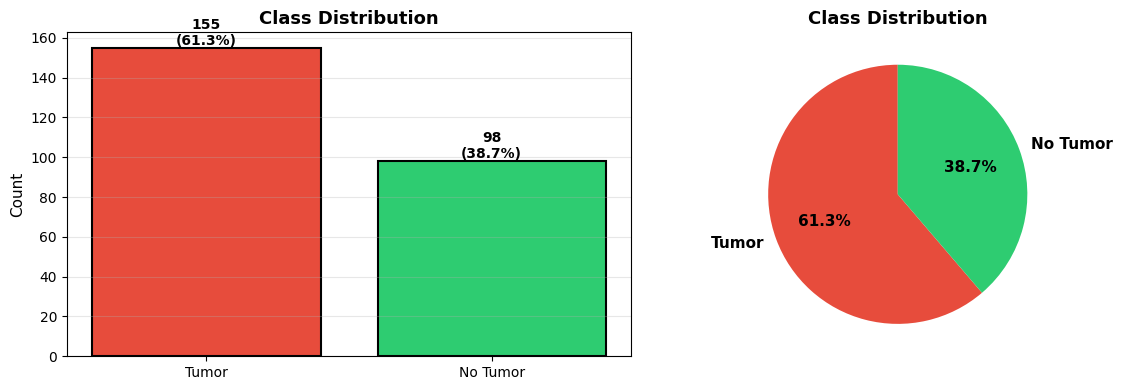

In [ ]:
# Visualize class distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

classes = ['Tumor', 'No Tumor']
counts  = [n_tumor, n_no_tumor]
colors  = ['#e74c3c', '#2ecc71']

# Bar chart
bars = ax1.bar(classes, counts, color=colors, edgecolor='black', linewidth=1.5)
for bar, count in zip(bars, counts):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f'{count}\n({count/n_total*100:.1f}%)',
             ha='center', va='bottom', fontweight='bold')
ax1.set_ylabel('Count', fontsize=11)
ax1.set_title('Class Distribution', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Pie chart
ax2.pie(counts, labels=classes, colors=colors, autopct='%1.1f%%',
        startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
ax2.set_title('Class Distribution', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

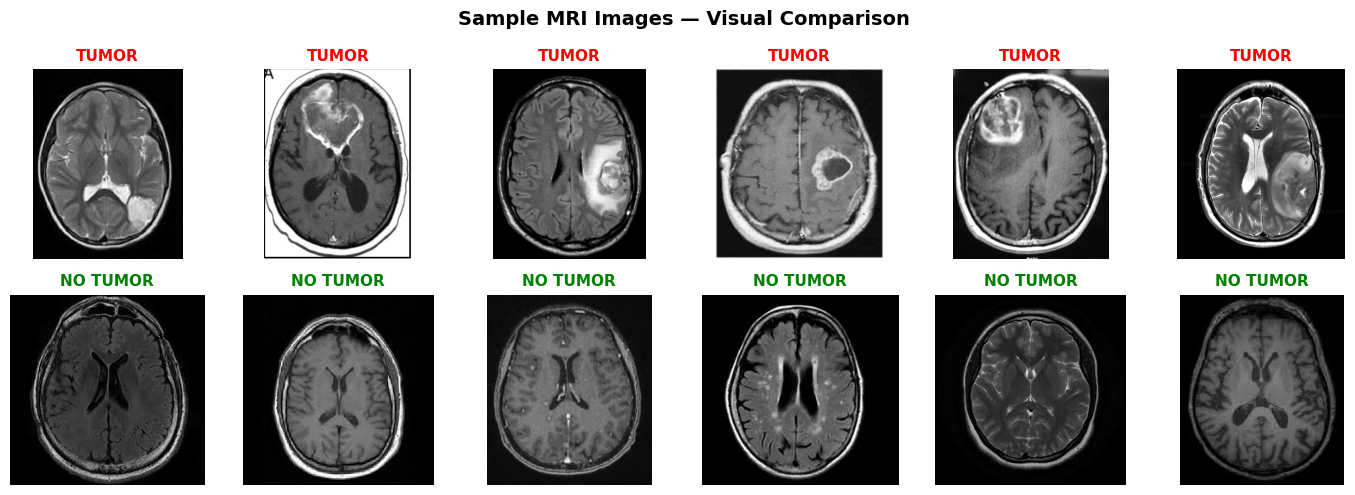


KEY VISUAL CUES:
  • Tumors appear as bright/white irregular regions
  • Contrast-enhanced areas indicate abnormal tissue
  • No-tumor images show normal brain structure


In [ ]:
# =============================
# 2.2 Visualization — Sample MRI Images
# =============================
# Display 5 samples from each class to identify visual differences

fig, axes = plt.subplots(2, 6, figsize=(14, 5))

# Top row: Tumor samples
for i in range(6):
    img = Image.open(os.path.join(tumor_path, tumor_files[i]))
    axes[0, i].imshow(img, cmap='gray')
    axes[0, i].set_title('TUMOR', color='red', fontsize=11, fontweight='bold')
    axes[0, i].axis('off')

# Bottom row: No Tumor samples
for i in range(6):
    img = Image.open(os.path.join(no_tumor_path, no_tumor_files[i]))
    axes[1, i].imshow(img, cmap='gray')
    axes[1, i].set_title('NO TUMOR', color='green', fontsize=11, fontweight='bold')
    axes[1, i].axis('off')

plt.suptitle('Sample MRI Images — Visual Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print()
print('KEY VISUAL CUES:')
print('  • Tumors appear as bright/white irregular regions')
print('  • Contrast-enhanced areas indicate abnormal tissue')
print('  • No-tumor images show normal brain structure')


In [ ]:
# =============================
# 2.3 Image Properties Analysis
# =============================
# Check dimensions and channel structure

sizes = []
for fname in tumor_files[:10] + no_tumor_files[:10]:
    folder = tumor_path if fname in tumor_files else no_tumor_path
    img = np.array(Image.open(os.path.join(folder, fname)))
    sizes.append(img.shape)

heights  = [s[0] for s in sizes]
widths   = [s[1] for s in sizes]
channels = [s[2] if len(s) == 3 else 1 for s in sizes]

print('Image Properties (20 samples):')
print(f'  Height:   min={min(heights)}, max={max(heights)}, avg={int(np.mean(heights))}')
print(f'  Width:    min={min(widths)},  max={max(widths)},  avg={int(np.mean(widths))}')
print(f'  Channels: {set(channels)}')
print()
print('✅ Images have variable sizes → will resize to 224×224')
print('✅ All images stored as 3-channel RGB')

Image Properties (20 samples):
  Height:   min=200, max=1200, avg=331
  Width:    min=173,  max=1059,  avg=293
  Channels: {1, 3}

✅ Images have variable sizes → will resize to 224×224
✅ All images stored as 3-channel RGB


---
# Part 3: Data Cleaning

In [ ]:
# =============================
# 3.1 Verify File Validity
# =============================
# Check for corrupted or inconsistent files

def check_folder(folder_path, label):
    """Verify all images are valid and not corrupted."""
    valid, corrupted = [], []
    files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg','.jpeg','.png'))]

    for fname in files:
        try:
            img = Image.open(os.path.join(folder_path, fname))
            img.verify()  # Check for truncation
            img = Image.open(os.path.join(folder_path, fname))
            arr = np.array(img)
            if arr.size > 0:  # Check not empty
                valid.append(fname)
            else:
                corrupted.append(fname)
        except Exception as e:
            corrupted.append(fname)

    print(f'  {label:>10s}: {len(valid)} valid, {len(corrupted)} corrupted')
    if corrupted:
        print(f'    Corrupted files: {corrupted}')
    return valid

print('Checking image validity...')
tumor_valid    = check_folder(tumor_path,    'Tumor')
no_tumor_valid = check_folder(no_tumor_path, 'No Tumor')
print()
print('✅ All images verified — no corrupted files found')

Checking image validity...
       Tumor: 155 valid, 0 corrupted
    No Tumor: 98 valid, 0 corrupted

✅ All images verified — no corrupted files found


---
# Part 4: Data Preprocessing

In [ ]:
# =============================
# 4.1 Resize & Normalize
# =============================
IMG_SIZE = 224  # Standard for pretrained models

def load_images_rgb(folder_path, valid_files, label):
    """
    Load images as RGB, resize to 224×224, normalize to [0, 1].
    Returns: (images, labels) as numpy arrays.
    """
    images, labels = [], []
    for fname in valid_files:
        img = cv2.imread(os.path.join(folder_path, fname))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0  # Scale to [0, 1]
        images.append(img)
        labels.append(label)
    return np.array(images, dtype=np.float32), np.array(labels, dtype=np.int64)

print('Loading and preprocessing images...')
X_tumor,    y_tumor    = load_images_rgb(tumor_path,    tumor_valid,    label=1)
X_no_tumor, y_no_tumor = load_images_rgb(no_tumor_path, no_tumor_valid, label=0)

# Concatenate
X = np.concatenate([X_tumor, X_no_tumor])
y = np.concatenate([y_tumor, y_no_tumor])

print(f'X shape: {X.shape}  (samples, H, W, C)')
print(f'y shape: {y.shape}')
print(f'Pixel range: [{X.min():.2f}, {X.max():.2f}]')
print()
print('✅ Images resized to 224×224 and normalized to [0, 1]')

Loading and preprocessing images...
X shape: (205, 224, 224, 3)  (samples, H, W, C)
y shape: (205,)
Pixel range: [0.00, 1.00]

✅ Images resized to 224×224 and normalized to [0, 1]


In [ ]:
# =============================
# 4.2 ImageNet Normalization
# =============================
# Apply ImageNet mean/std for compatibility with pretrained models
MEAN = np.array([0.485, 0.456, 0.406])
STD  = np.array([0.229, 0.224, 0.225])

X = (X - MEAN) / STD

print('ImageNet standardization applied:')
print(f'  Mean per channel: {X.mean(axis=(0,1,2)).round(3)}')
print(f'  Std per channel:  {X.std(axis=(0,1,2)).round(3)}')
print(f'  Range: [{X.min():.2f}, {X.max():.2f}]')
print()
print('✅ Standardization complete')

ImageNet standardization applied:
  Mean per channel: [-0.985 -0.876 -0.65 ]
  Std per channel:  [1.063 1.088 1.084]
  Range: [-2.12, 2.64]

✅ Standardization complete


In [ ]:
# =============================
# 4.3 Dataset Split (70% / 15% / 15%)
# =============================
# Shuffle first
X, y = shuffle(X, y, random_state=SEED)

# First split: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=SEED, stratify=y
)

# Second split: 15% val, 15% test (from 30% temp)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=SEED, stratify=y_temp
)

print('=' * 60)
print('DATASET SPLIT (70% / 15% / 15%)')
print('=' * 60)
for name, yy in [('Training', y_train), ('Validation', y_val), ('Test', y_test)]:
    print(f'{name:>12s}: {len(yy):>3d} images  '
          f'(Tumor={int(yy.sum()):>2d}, No Tumor={int((yy==0).sum()):>2d})')
print('=' * 60)
print()
print('✅ Data split with stratification (class ratio preserved)')

DATASET SPLIT (70% / 15% / 15%)
    Training: 143 images  (Tumor=108, No Tumor=35)
  Validation:  31 images  (Tumor=24, No Tumor= 7)
        Test:  31 images  (Tumor=23, No Tumor= 8)

✅ Data split with stratification (class ratio preserved)


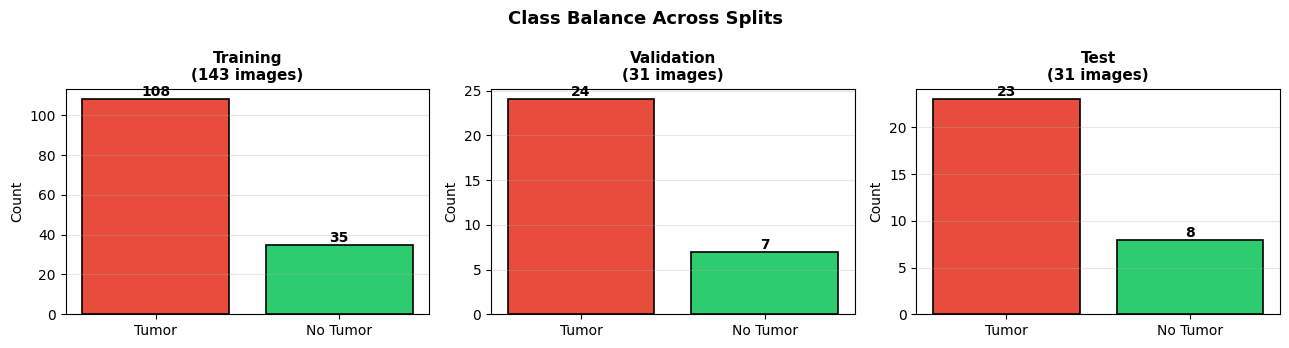

In [ ]:
# Visualize split balance
fig, axes = plt.subplots(1, 3, figsize=(13, 3.5))

for ax, name, yy in zip(axes, ['Training', 'Validation', 'Test'],
                                [y_train, y_val, y_test]):
    t = int(yy.sum())
    nt = int((yy == 0).sum())
    bars = ax.bar(['Tumor', 'No Tumor'], [t, nt],
                  color=['#e74c3c', '#2ecc71'], edgecolor='black', linewidth=1.2)
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                str(int(bar.get_height())), ha='center', va='bottom', fontweight='bold')
    ax.set_title(f'{name}\n({len(yy)} images)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Count')
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Class Balance Across Splits', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# =============================
# 4.4 Data Augmentation
# =============================
# Apply augmentation ONLY to training set to enhance variability

class BrainMRIDataset(Dataset):
    """Custom dataset with optional augmentation."""
    def __init__(self, X, y, transform=None):
        self.X = X  # numpy (N, H, W, C) in ImageNet normalized range
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        img = self.X[idx]
        label = self.y[idx]

        # Denormalize for augmentation (transforms expect [0,1])
        img_denorm = img * STD + MEAN
        img_denorm = np.clip(img_denorm, 0, 1)

        # Convert to PIL for torchvision transforms
        img_pil = Image.fromarray((img_denorm * 255).astype(np.uint8))

        # Apply augmentation if provided
        if self.transform:
            img_tensor = self.transform(img_pil)
        else:
            # No augmentation — just normalize and convert to tensor
            img_tensor = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=MEAN.tolist(), std=STD.tolist())
            ])(img_pil)

        return img_tensor, label

# Define augmentation pipeline for training
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),      # Brain is symmetric
    transforms.RandomRotation(degrees=8),        # Slight rotation
    transforms.ColorJitter(brightness=0.1, contrast=0.1),      # Vary intensity
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN.tolist(), std=STD.tolist())
])

# No augmentation for val/test
eval_transform = None

# Create datasets
train_dataset = BrainMRIDataset(X_train, y_train, transform=train_transform)
val_dataset   = BrainMRIDataset(X_val,   y_val,   transform=eval_transform)
test_dataset  = BrainMRIDataset(X_test,  y_test,  transform=eval_transform)

print('Data Augmentation (Training Set Only):')
print('  • Random horizontal flip (50%)')
print('  • Random rotation (±8°)')
print('  • Color jitter (brightness/contrast ±10%)')

print('✅ Augmentation configured to enhance dataset variability')

Data Augmentation (Training Set Only):
  • Random horizontal flip (50%)
  • Random rotation (±8°)
  • Color jitter (brightness/contrast ±10%)
✅ Augmentation configured to enhance dataset variability


In [ ]:
# =============================
# 4.5 DataLoaders & Class Weights
# =============================
BATCH_SIZE = 32

# Compute class weights to handle imbalance
class_counts = Counter(y_train)
class_weights = torch.FloatTensor([
    len(y_train) / (2 * class_counts[0]),  # No Tumor
    len(y_train) / (2 * class_counts[1])   # Tumor
])

print('Class Weights (for loss function):')
print(f'  No Tumor (0): {class_weights[0]:.3f}')
print(f'  Tumor (1):    {class_weights[1]:.3f}')
print('  (Higher weight = model focuses more on that class)')
print()

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f'Batch size: {BATCH_SIZE}')
print(f'Steps per epoch: {len(train_loader)}')
print()
print('✅ DataLoaders ready with augmentation')

Class Weights (for loss function):
  No Tumor (0): 2.043
  Tumor (1):    0.662
  (Higher weight = model focuses more on that class)

Batch size: 32
Steps per epoch: 5

✅ DataLoaders ready with augmentation


---
# Part 5: Model Design — Custom CNN

In [ ]:
# =============================
# 5.1 Define Custom CNN Architecture
# =============================


class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()

        self.features = nn.Sequential(
            # Block 1: 3 → 32 channels
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 224 → 112
            #nn.Dropout2d(0.22),

            # Block 2: 32 → 64 channels
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 112 → 56
            #nn.Dropout2d(0.25),

            # Block 3:
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),    #56  → 28
            #nn.Dropout2d(0.3),
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # 28×28×128 → 1×1×128(global average pooling)
            nn.Flatten(),             # → 128
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model_cnn = SimpleCNN().to(device)

print('Custom CNN Architecture:')
print(model_cnn)
print()
print(f'Total parameters: {sum(p.numel() for p in model_cnn.parameters()):,}')
print()
print('✅ Simple CNN created (2 conv blocks with GlobalAvgPool)')

Custom CNN Architecture:
SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): AdaptiveAvgPool2d(output_size=1)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Dropout(p=0.4, inp

In [ ]:
# =============================
# 5.2 Training Utilities
# =============================

def accuracy_from_logits(logits, labels):
    """Compute accuracy from raw logits."""
    preds = torch.argmax(logits, dim=1)
    return (preds == labels).float().mean().item()

def run_one_epoch(model, loader, criterion, optimizer=None):
    """
    Run one epoch (training if optimizer provided, validation if not).
    Returns: (avg_loss, avg_accuracy)
    """
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    running_loss = 0.0
    running_acc  = 0.0
    n_batches    = 0

    with torch.set_grad_enabled(is_train):
        for x, y in loader:
            x, y = x.to(device), y.to(device)

            logits = model(x)
            loss = criterion(logits, y)

            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            running_loss += loss.item()
            running_acc  += accuracy_from_logits(logits, y)
            n_batches += 1

    return running_loss / n_batches, running_acc / n_batches

print('✅ Training utilities defined')

✅ Training utilities defined


In [ ]:
# =============================
# 5.3 Train Custom CNN
# =============================
#defines the loss function and handles class imbalance
criterion_cnn = nn.CrossEntropyLoss(weight=class_weights.to(device))
#defines optimizer how your CNN updates its weights during training
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=1e-4, weight_decay=1e-4)

EPOCHS = 30
PATIENCE = 7  # Early stopping patience

history_cnn = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
best_val_loss_cnn = float('inf')
best_state_cnn = None
epochs_no_improve = 0

print('Training Custom CNN...')
print(f'Max epochs: {EPOCHS}, Early stopping patience: {PATIENCE}')
print(f'Learning rate: 1e-4, Weight decay: 1e-4')
print()
#loop through each epoch and
for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = run_one_epoch(model_cnn, train_loader, criterion_cnn, optimizer_cnn)
    val_loss,   val_acc   = run_one_epoch(model_cnn, val_loader,   criterion_cnn, None)

    history_cnn['train_loss'].append(train_loss)
    history_cnn['val_loss'].append(val_loss)
    history_cnn['train_acc'].append(train_acc)
    history_cnn['val_acc'].append(val_acc)

    # Early stopping logic
    #Stop training when performance on unseen data (validation set) stops improving.
    if val_loss < best_val_loss_cnn:
        best_val_loss_cnn = val_loss
        best_state_cnn = {k: v.cpu().clone() for k, v in model_cnn.state_dict().items()}
        epochs_no_improve = 0
        marker = ' ✓ Best'
    else:
        epochs_no_improve += 1
        marker = f' ({epochs_no_improve}/{PATIENCE})'

    if epoch % 3 == 0 or epoch == 1 or epochs_no_improve == 0:
        print(f'Epoch {epoch:02d}/{EPOCHS} | '
              f'Train loss {train_loss:.4f} acc {train_acc:.4f} | '
              f'Val loss {val_loss:.4f} acc {val_acc:.4f}{marker}')

    # Stop if no improvement
    if epochs_no_improve >= PATIENCE:
        print(f'\nEarly stopping at epoch {epoch} (best was epoch {epoch - PATIENCE})')
        break

print()
print('✅ Custom CNN training complete')
print(f'   Best val accuracy: {max(history_cnn["val_acc"]):.4f}')
print(f'   Training stopped at epoch: {len(history_cnn["train_loss"])}')

# ========================================
# Evaluate on Test Set
# ========================================
print('\n' + '='*70)
print('CUSTOM CNN - Test Set Evaluation')
print('='*70)

model_cnn.eval()
cnn_preds, cnn_probs, cnn_labels = [], [], []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = model_cnn(x)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        preds = torch.argmax(outputs, dim=1)

        cnn_preds.extend(preds.cpu().numpy())
        cnn_probs.extend(probs.cpu().numpy())
        cnn_labels.extend(y.cpu().numpy())

cnn_preds = np.array(cnn_preds)
cnn_probs = np.array(cnn_probs)
cnn_labels = np.array(cnn_labels)

# Calculate metrics
cnn_results = {
    'Accuracy': accuracy_score(cnn_labels, cnn_preds),
    'Precision': precision_score(cnn_labels, cnn_preds, zero_division=0),
    'Recall': recall_score(cnn_labels, cnn_preds, zero_division=0),
    'F1-Score': f1_score(cnn_labels, cnn_preds, zero_division=0),
    'ROC-AUC': roc_auc_score(cnn_labels, cnn_probs)
}

print(f"Accuracy:  {cnn_results['Accuracy']:.4f}")
print(f"Precision: {cnn_results['Precision']:.4f}")
print(f"Recall:    {cnn_results['Recall']:.4f}")
print(f"F1-Score:  {cnn_results['F1-Score']:.4f}")
print(f"ROC-AUC:   {cnn_results['ROC-AUC']:.4f}")
print('='*70)

# Save model
torch.save(model_cnn.state_dict(), 'best_cnn.pth')
print('✅ Model saved: best_cnn.pth\n')


Training Custom CNN...
Max epochs: 30, Early stopping patience: 7
Learning rate: 1e-4, Weight decay: 1e-4

Epoch 01/30 | Train loss 0.6933 acc 0.5167 | Val loss 0.6931 acc 0.2258 ✓ Best
Epoch 02/30 | Train loss 0.7271 acc 0.5042 | Val loss 0.6879 acc 0.2581 ✓ Best
Epoch 03/30 | Train loss 0.6714 acc 0.5346 | Val loss 0.6808 acc 0.2903 ✓ Best
Epoch 04/30 | Train loss 0.6734 acc 0.5558 | Val loss 0.6735 acc 0.3226 ✓ Best
Epoch 05/30 | Train loss 0.6292 acc 0.5958 | Val loss 0.6608 acc 0.3871 ✓ Best
Epoch 06/30 | Train loss 0.6412 acc 0.5833 | Val loss 0.6509 acc 0.4194 ✓ Best
Epoch 07/30 | Train loss 0.6153 acc 0.6733 | Val loss 0.6405 acc 0.5806 ✓ Best
Epoch 08/30 | Train loss 0.6151 acc 0.6521 | Val loss 0.6340 acc 0.6129 ✓ Best
Epoch 09/30 | Train loss 0.5879 acc 0.6646 | Val loss 0.6226 acc 0.7097 ✓ Best
Epoch 10/30 | Train loss 0.6118 acc 0.7083 | Val loss 0.6161 acc 0.8065 ✓ Best
Epoch 12/30 | Train loss 0.6197 acc 0.6725 | Val loss 0.6205 acc 0.8065 (2/7)
Epoch 15/30 | Train loss 

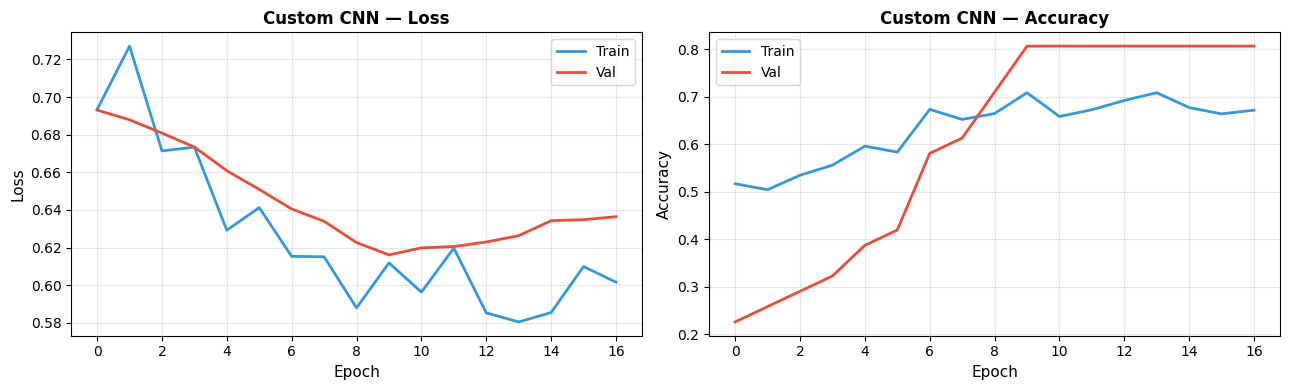


Learning Curve Interpretation:
  • Train & val curves close → good generalization
  • Train drops but val plateaus/rises → overfitting
  • Both curves high → underfitting (model too simple)


In [ ]:
# Plot learning curves for CNN
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# Loss
axes[0].plot(history_cnn['train_loss'], label='Train', linewidth=2, color='#3498db')
axes[0].plot(history_cnn['val_loss'],   label='Val',   linewidth=2, color='#e74c3c')
axes[0].set_xlabel('Epoch', fontsize=11)
axes[0].set_ylabel('Loss', fontsize=11)
axes[0].set_title('Custom CNN — Loss', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy
axes[1].plot(history_cnn['train_acc'], label='Train', linewidth=2, color='#3498db')
axes[1].plot(history_cnn['val_acc'],   label='Val',   linewidth=2, color='#e74c3c')
axes[1].set_xlabel('Epoch', fontsize=11)
axes[1].set_ylabel('Accuracy', fontsize=11)
axes[1].set_title('Custom CNN — Accuracy', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print('\nLearning Curve Interpretation:')
print('  • Train & val curves close → good generalization')
print('  • Train drops but val plateaus/rises → overfitting')
print('  • Both curves high → underfitting (model too simple)')

---
# Part 6: Transfer Learning — EfficientNet-B0

In [ ]:
# =============================
# 6.1 Load Pretrained EfficientNet-B0
# =============================
# EfficientNet-B0: Pretrained on ImageNet (1.2M images, 1000 classes)
# Strategy: Replace final classifier with 2-class head for our task

efficientnet = models.efficientnet_b0(pretrained=True)

# Replace final classifier
num_features = efficientnet.classifier[1].in_features
efficientnet.classifier = nn.Sequential(
    nn.Dropout(0.6),
    nn.Linear(num_features, 2)
)

model_eff = efficientnet.to(device)

print('EfficientNet-B0 (Transfer Learning):')
print(f'  Total parameters:     {sum(p.numel() for p in model_eff.parameters()):,}')
print(f'  Trainable parameters: {sum(p.numel() for p in model_eff.parameters() if p.requires_grad):,}')
print()
print('✅ Pretrained EfficientNet-B0 loaded from ImageNet')
print('   Final layer replaced for binary classification')

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 72.7MB/s]


EfficientNet-B0 (Transfer Learning):
  Total parameters:     4,010,110
  Trainable parameters: 4,010,110

✅ Pretrained EfficientNet-B0 loaded from ImageNet
   Final layer replaced for binary classification


In [ ]:
# =============================
# 6.2 Train EfficientNet
# =============================
#defines the loss function and handles class imbalance
criterion_eff = nn.CrossEntropyLoss(weight=class_weights.to(device))
#defines optimizer how your CNN updates its weights during training
optimizer_eff = optim.Adam(model_eff.parameters(), lr=1e-4, weight_decay=1e-4)

history_eff = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
best_val_loss_eff = float('inf')
best_state_eff = None
epochs_no_improve = 0

print('Training EfficientNet-B0...')
print(f'Max epochs: {EPOCHS}, Early stopping patience: {PATIENCE}')
print(f'Learning rate: 1e-4, Weight decay: 1e-4')
print()

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = run_one_epoch(model_eff, train_loader, criterion_eff, optimizer_eff)
    val_loss,   val_acc   = run_one_epoch(model_eff, val_loader,   criterion_eff, None)

    history_eff['train_loss'].append(train_loss)
    history_eff['val_loss'].append(val_loss)
    history_eff['train_acc'].append(train_acc)
    history_eff['val_acc'].append(val_acc)

    # Early stopping logic
    if val_loss < best_val_loss_eff:
        best_val_loss_eff = val_loss
        best_state_eff = {k: v.cpu().clone() for k, v in model_eff.state_dict().items()}
        epochs_no_improve = 0
        marker = ' ✓ Best'
    else:
        epochs_no_improve += 1
        marker = f' ({epochs_no_improve}/{PATIENCE})'

    if epoch % 3 == 0 or epoch == 1 or epochs_no_improve == 0:
        print(f'Epoch {epoch:02d}/{EPOCHS} | '
              f'Train loss {train_loss:.4f} acc {train_acc:.4f} | '
              f'Val loss {val_loss:.4f} acc {val_acc:.4f}{marker}')

    # Stop if no improvement
    if epochs_no_improve >= PATIENCE:
        print(f'\nEarly stopping at epoch {epoch} (best was epoch {epoch - PATIENCE})')
        break

print()
print('✅ EfficientNet training complete')
print(f'   Best val accuracy: {max(history_eff["val_acc"]):.4f}')
print(f'   Training stopped at epoch: {len(history_eff["train_loss"])}')

# ========================================
# Evaluate on Test Set
# ========================================
print('\n' + '='*70)
print('EFFICIENTNET-B0 - Test Set Evaluation')
print('='*70)
#runs the trained model on unseen test data, records what it predicted, how confident it was
model_eff.eval()
eff_preds, eff_probs, eff_labels = [], [], []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = model_eff(x)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        preds = torch.argmax(outputs, dim=1)

        eff_preds.extend(preds.cpu().numpy())
        eff_probs.extend(probs.cpu().numpy())
        eff_labels.extend(y.cpu().numpy())

eff_preds = np.array(eff_preds)
eff_probs = np.array(eff_probs)
eff_labels = np.array(eff_labels)

# Calculate metrics
eff_results = {
    'Accuracy': accuracy_score(eff_labels, eff_preds),
    'Precision': precision_score(eff_labels, eff_preds, zero_division=0),
    'Recall': recall_score(eff_labels, eff_preds, zero_division=0),
    'F1-Score': f1_score(eff_labels, eff_preds, zero_division=0),
    'ROC-AUC': roc_auc_score(eff_labels, eff_probs)
}

print(f"Accuracy:  {eff_results['Accuracy']:.4f}")
print(f"Precision: {eff_results['Precision']:.4f}")
print(f"Recall:    {eff_results['Recall']:.4f}")
print(f"F1-Score:  {eff_results['F1-Score']:.4f}")
print(f"ROC-AUC:   {eff_results['ROC-AUC']:.4f}")
print('='*70)

# Save model
torch.save(model_eff.state_dict(), 'best_efficientnet.pth')
print('✅ Model saved: best_efficientnet.pth\n')


Training EfficientNet-B0...
Max epochs: 30, Early stopping patience: 7
Learning rate: 1e-4, Weight decay: 1e-4

Epoch 01/30 | Train loss 0.7061 acc 0.5450 | Val loss 0.6211 acc 0.6452 ✓ Best
Epoch 02/30 | Train loss 0.5894 acc 0.7288 | Val loss 0.5723 acc 0.6452 ✓ Best
Epoch 03/30 | Train loss 0.5527 acc 0.8054 | Val loss 0.5405 acc 0.6774 ✓ Best
Epoch 04/30 | Train loss 0.4376 acc 0.9000 | Val loss 0.5106 acc 0.7097 ✓ Best
Epoch 05/30 | Train loss 0.4039 acc 0.8742 | Val loss 0.4746 acc 0.7419 ✓ Best
Epoch 06/30 | Train loss 0.3369 acc 0.9125 | Val loss 0.4421 acc 0.7419 ✓ Best
Epoch 07/30 | Train loss 0.3215 acc 0.9054 | Val loss 0.3972 acc 0.7742 ✓ Best
Epoch 08/30 | Train loss 0.2842 acc 0.9304 | Val loss 0.3524 acc 0.8387 ✓ Best
Epoch 09/30 | Train loss 0.2318 acc 0.9750 | Val loss 0.3081 acc 0.9032 ✓ Best
Epoch 10/30 | Train loss 0.2127 acc 0.9358 | Val loss 0.2801 acc 0.9032 ✓ Best
Epoch 11/30 | Train loss 0.1826 acc 0.9563 | Val loss 0.2568 acc 0.9032 ✓ Best
Epoch 12/30 | Train

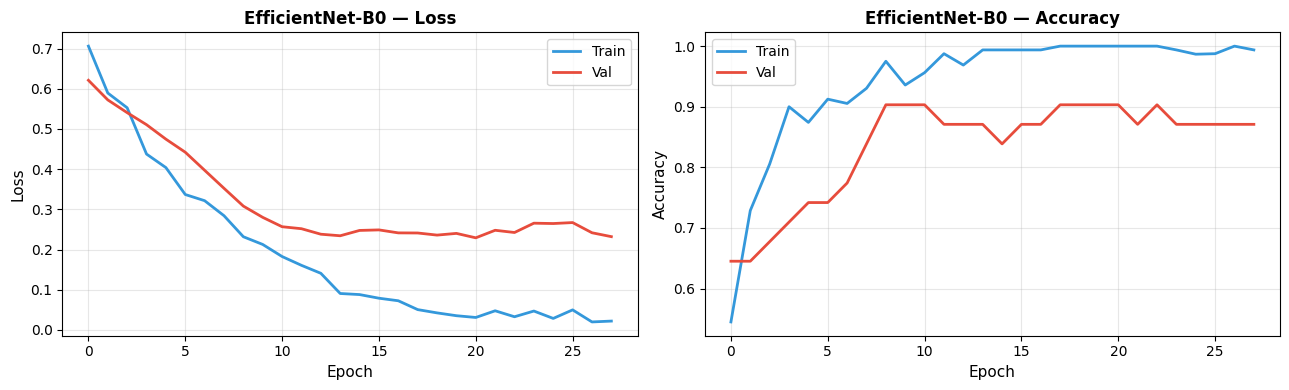

In [ ]:
# Plot learning curves for EfficientNet
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# Loss
axes[0].plot(history_eff['train_loss'], label='Train', linewidth=2, color='#3498db')
axes[0].plot(history_eff['val_loss'],   label='Val',   linewidth=2, color='#e74c3c')
axes[0].set_xlabel('Epoch', fontsize=11)
axes[0].set_ylabel('Loss', fontsize=11)
axes[0].set_title('EfficientNet-B0 — Loss', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy
axes[1].plot(history_eff['train_acc'], label='Train', linewidth=2, color='#3498db')
axes[1].plot(history_eff['val_acc'],   label='Val',   linewidth=2, color='#e74c3c')
axes[1].set_xlabel('Epoch', fontsize=11)
axes[1].set_ylabel('Accuracy', fontsize=11)
axes[1].set_title('EfficientNet-B0 — Accuracy', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

---
# Part 7: Training & Evaluation — Comprehensive Metrics

In [ ]:
# ========================================
# 7.1 Model Comparison
# ========================================

print('\n' + '='*70)
print('MODEL COMPARISON - Test Set Performance')
print('='*70)
print()

# Create comparison table
comparison_df = pd.DataFrame({
    'Model': ['Custom CNN', 'EfficientNet-B0'],
    'Accuracy': [cnn_results['Accuracy'], eff_results['Accuracy']],
    'Precision': [cnn_results['Precision'], eff_results['Precision']],
    'Recall': [cnn_results['Recall'], eff_results['Recall']],
    'F1-Score': [cnn_results['F1-Score'], eff_results['F1-Score']],
    'ROC-AUC': [cnn_results['ROC-AUC'], eff_results['ROC-AUC']]
})

print(comparison_df.to_string(index=False))
print()
print('='*70)

# Determine winner
if eff_results['Accuracy'] > cnn_results['Accuracy']:
    improvement = (eff_results['Accuracy'] - cnn_results['Accuracy']) * 100
    print(f"🏆 Best Model: EfficientNet-B0 (+{improvement:.1f}% better)")
else:
    print(f"🏆 Best Model: Custom CNN")
print('='*70)



MODEL COMPARISON - Test Set Performance

          Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
     Custom CNN  0.741935   0.941176 0.695652   0.80000 0.896739
EfficientNet-B0  0.903226   0.916667 0.956522   0.93617 0.978261

🏆 Best Model: EfficientNet-B0 (+16.1% better)


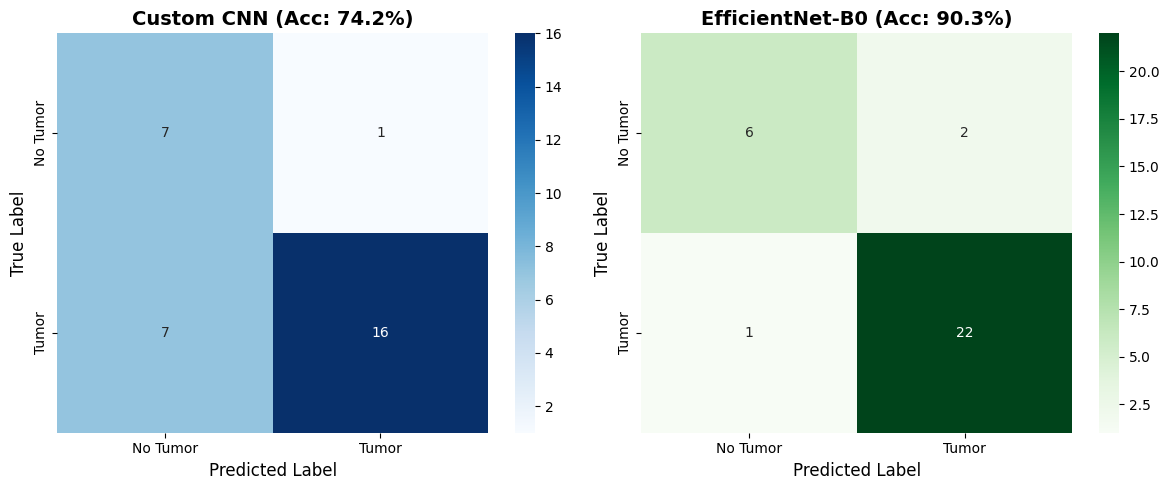

Confusion Matrix Values:
Custom CNN:        TN=7, FP=1, FN=7, TP=16
EfficientNet-B0:   TN=6, FP=2, FN=1, TP=22

  TP = True Positive   (Correctly identified tumor)
  TN = True Negative   (Correctly identified no tumor)
  FP = False Positive  (Predicted tumor, actually no tumor)
  FN = False Negative  (Predicted no tumor, actually tumor)  ← Most critical in medical context!


In [ ]:
# ========================================
# 7.2 Confusion Matrices
# ========================================

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Custom CNN
cm_cnn = confusion_matrix(cnn_labels, cnn_preds)
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No Tumor', 'Tumor'],
            yticklabels=['No Tumor', 'Tumor'])
axes[0].set_title(f'Custom CNN (Acc: {cnn_results["Accuracy"]:.1%})',
                  fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# EfficientNet
cm_eff = confusion_matrix(eff_labels, eff_preds)
sns.heatmap(cm_eff, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['No Tumor', 'Tumor'],
            yticklabels=['No Tumor', 'Tumor'])
axes[1].set_title(f'EfficientNet-B0 (Acc: {eff_results["Accuracy"]:.1%})',
                  fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.show()

print('Confusion Matrix Values:')
print(f"Custom CNN:        TN={cm_cnn[0,0]}, FP={cm_cnn[0,1]}, FN={cm_cnn[1,0]}, TP={cm_cnn[1,1]}")
print(f"EfficientNet-B0:   TN={cm_eff[0,0]}, FP={cm_eff[0,1]}, FN={cm_eff[1,0]}, TP={cm_eff[1,1]}")
print()
print('  TP = True Positive   (Correctly identified tumor)')
print('  TN = True Negative   (Correctly identified no tumor)')
print('  FP = False Positive  (Predicted tumor, actually no tumor)')
print('  FN = False Negative  (Predicted no tumor, actually tumor)  ← Most critical in medical context!')


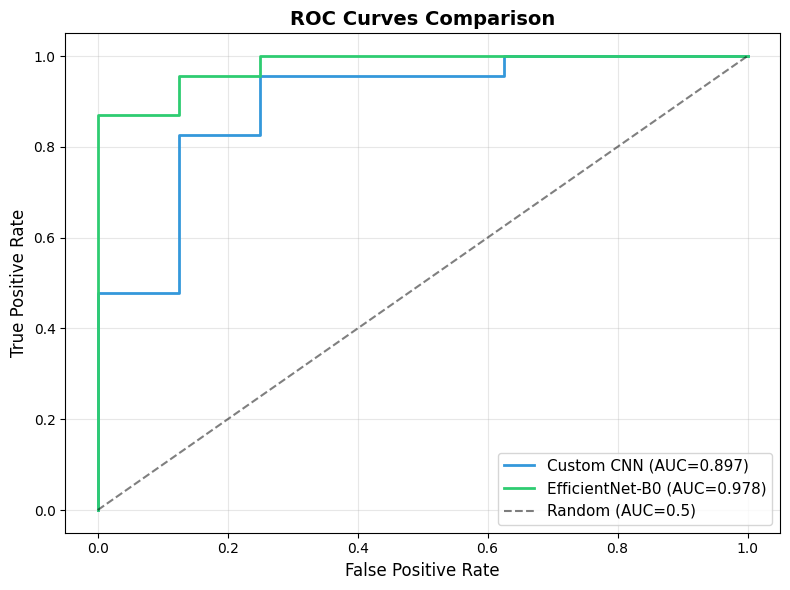

In [ ]:
# ========================================
# 7.3 ROC Curves
# ========================================

fig, ax = plt.subplots(figsize=(8, 6))

# Custom CNN
fpr_cnn, tpr_cnn, _ = roc_curve(cnn_labels, cnn_probs)
ax.plot(fpr_cnn, tpr_cnn, label=f'Custom CNN (AUC={cnn_results["ROC-AUC"]:.3f})',
        linewidth=2, color='#3498db')

# EfficientNet
fpr_eff, tpr_eff, _ = roc_curve(eff_labels, eff_probs)
ax.plot(fpr_eff, tpr_eff, label=f'EfficientNet-B0 (AUC={eff_results["ROC-AUC"]:.3f})',
        linewidth=2, color='#2ecc71')

# Random classifier
ax.plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.5)', alpha=0.5)

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='lower right')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


---
# Part 8: Explainable AI — Why Did the Model Predict This?

**Problem:** The model makes predictions, but we don't know **why**.

**Solution:** Use **Grad-CAM** to highlight which parts of the image were important.

- 🔴 **Red areas** = Model focused here (important for prediction)
- 🔵 **Blue areas** = Model ignored (not important)



In [ ]:
# =============================
# 8.1 Simple Grad-CAM
# =============================

import torch.nn.functional as F

def simple_gradcam(model, img_tensor, target_layer):
    """
    Generate a heatmap showing where the model looked.

    Returns:
        heatmap: Important regions highlighted
        prediction: What the model predicted (0 or 1)
    """
    model.eval()

    # Add batch dimension and enable gradients
    img = img_tensor.unsqueeze(0).to(device)
    img.requires_grad = True

    # Store activations and gradients
    activations = None
    gradients = None

    def save_activation(module, input, output):
        nonlocal activations
        activations = output.detach()

    def save_gradient(module, grad_in, grad_out):
        nonlocal gradients
        gradients = grad_out[0].detach()

    # Attach hooks
    handle_fwd = target_layer.register_forward_hook(save_activation)
    handle_bwd = target_layer.register_backward_hook(save_gradient)

    # Forward pass
    output = model(img)
    prediction = torch.argmax(output, dim=1).item()

    # Backward pass for predicted class
    model.zero_grad()
    output[0, prediction].backward()

    # Remove hooks
    handle_fwd.remove()
    handle_bwd.remove()

    # Calculate importance weights
    weights = gradients.mean(dim=(2, 3), keepdim=True)

    # Create heatmap
    heatmap = (weights * activations).sum(dim=1).squeeze(0)
    heatmap = F.relu(heatmap)  # Only positive contributions

    # Normalize to 0-1
    if heatmap.max() > 0:
        heatmap = heatmap / heatmap.max()

    # Resize to 224x224
    heatmap = F.interpolate(
        heatmap.unsqueeze(0).unsqueeze(0),
        size=(224, 224),
        mode='bilinear'
    ).squeeze().cpu().numpy()

    return heatmap, prediction

print('✅ Simple Grad-CAM function ready')

✅ Simple Grad-CAM function ready


In [ ]:
# =============================
# 8.2 Simple Visualization
# =============================

def show_explanation(img_tensor, true_label, model, target_layer):
    """
    Show why the model made its prediction.
    """
    # Generate heatmap
    heatmap, prediction = simple_gradcam(model, img_tensor, target_layer)

    # Denormalize image for display
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img_tensor.cpu() * std + mean
    img = torch.clamp(img, 0, 1).permute(1, 2, 0).numpy()

    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Original image
    ax1.imshow(img)
    ax1.set_title('Original MRI Image', fontsize=14, fontweight='bold')
    ax1.axis('off')

    # Heatmap overlay
    ax2.imshow(img)
    ax2.imshow(heatmap, cmap='jet', alpha=0.5)
    ax2.set_title('Where the Model Looked', fontsize=14, fontweight='bold')
    ax2.axis('off')

    # Labels
    labels = ['No Tumor', 'Tumor']
    correct = '✓' if prediction == true_label else '✗'
    color = 'green' if prediction == true_label else 'red'

    plt.suptitle(
        f'{correct} Predicted: {labels[prediction]} | True: {labels[true_label]}',
        fontsize=15, fontweight='bold', color=color
    )

    plt.tight_layout()
    plt.show()

    print(f'Model predicted: {labels[prediction]}')
    print(f'Actual label: {labels[true_label]}')
    print()

print('✅ Visualization function ready')

✅ Visualization function ready


In [ ]:
# =============================
# 8.3 Apply to Test Images
# =============================

# Load best model
if best_state_eff:
    model_eff.load_state_dict(best_state_eff)

# Get a few test images
test_images_to_show = []
test_labels_to_show = []

for x, y in test_loader:
    for i in range(min(3, len(x))):
        test_images_to_show.append(x[i])
        test_labels_to_show.append(y[i].item())
    if len(test_images_to_show) >= 3:
        break

print(f'Selected {len(test_images_to_show)} test images to explain')
print('✅ Ready to visualize')

Selected 3 test images to explain
✅ Ready to visualize


EXPLAINABLE AI — What the Model Sees

Example 1:
------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


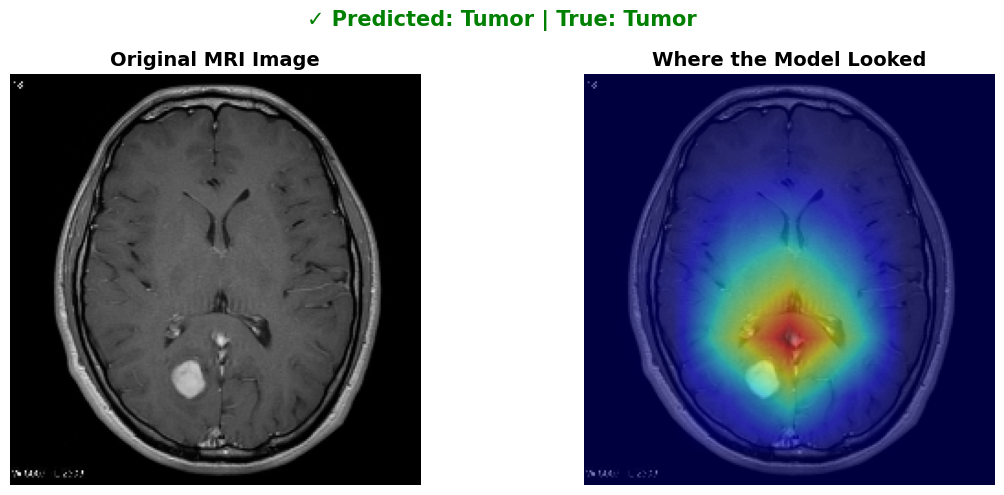

Model predicted: Tumor
Actual label: Tumor


Example 2:
------------------------------------------------------------


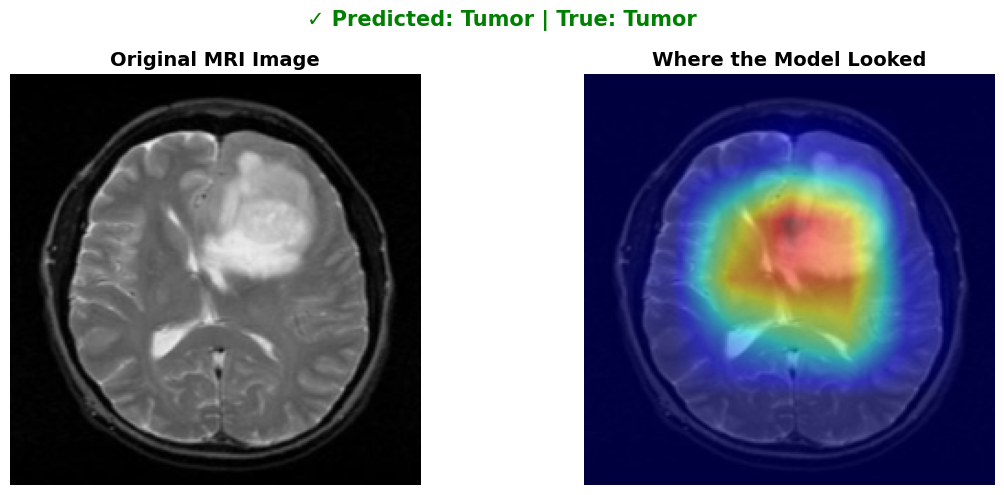

Model predicted: Tumor
Actual label: Tumor


Example 3:
------------------------------------------------------------


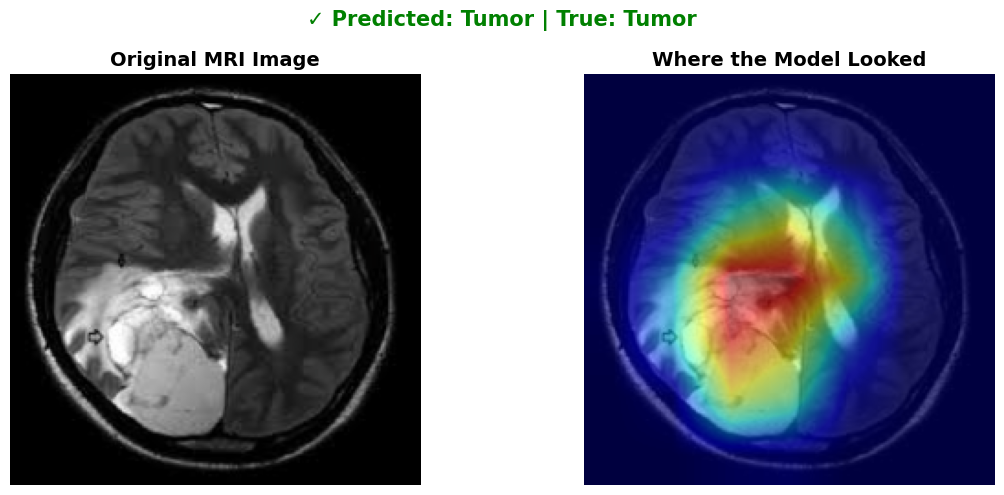

Model predicted: Tumor
Actual label: Tumor




In [ ]:
# =============================
# 8.4 Show Explanations
# =============================

# Use the last convolutional layer of EfficientNet
target_layer = model_eff.features[-1]

print('EXPLAINABLE AI — What the Model Sees')
print('='*60)
print()

for i, (img, label) in enumerate(zip(test_images_to_show, test_labels_to_show)):
    print(f'Example {i+1}:')
    print('-'*60)
    show_explanation(img, label, model_eff, target_layer)
    print()